https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/data



In [4]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = "Stock_Data/Stocks"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1a-I9epOaGdMqEQjvMO-SGs4iDefnoraJ/Stocks


In [5]:
"""LSTM Model"""

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")


import plotly.graph_objects as go

import xgboost as xgb

import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

class PriceClassifier():

  stock: str
  stock_history_df: pd.DataFrame
  model: Sequential

  def __init__(self, stock: str):
    self.stock = stock
    self.stock_history_df = self._get_stock_history_df()
    self.train_data, self.test_data, self.val_data = self._create_train_and_test_set()
    self.X_train, self.y_train, self.X_val, self.y_val, self.X_test = self._preprocess()

  def _get_stock_history_df(self):
    stock_country = "us"
    stock_history_path = f"{self.stock}.{stock_country}.txt"
    return pd.read_csv(stock_history_path)

  def plot_daily_close(self):
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Date', y='Close', data=self.stock_history_df)
    plt.xlabel('Date')
    plt.ylabel('Close price')
    plt.title('AMTD daily close price 2010-2017')
    plt.show()

  def _create_train_and_test_set(self):
    train_size = 0.8
    test_size = 0.1
    validation_size = 0.1
    dataset = self.stock_history_df

    train_end = int(len(dataset) * train_size)
    test_end = train_end + int(len(dataset) * test_size)

    train_data = dataset.iloc[:train_end]
    test_data = dataset.iloc[train_end:test_end]
    validation_data = dataset.iloc[test_end:]
    return train_data, test_data, validation_data

  def plot_train_test_val(self):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=self.train_data['Date'], y=self.train_data['Close'], mode='lines', name='Train data'))
    fig.add_trace(go.Scatter(x=self.test_data['Date'], y=self.test_data['Close'], mode='lines', name='Test data'))
    fig.add_trace(go.Scatter(x=self.val_data['Date'], y=self.val_data['Close'], mode='lines', name='Validation data'))


    fig.update_layout(
        title=f'{self.stock.upper()} daily close price 2010-2017',
        xaxis_title='Date',
        yaxis_title='Close price',
    )

    fig.show()

  def _preprocess(self):
    X_train = self.train_data.drop(columns=['Close', 'Date'])
    y_train = self.train_data['Close']
    X_validation = self.val_data.drop(columns=['Close', 'Date'])
    y_validation = self.val_data['Close']
    X_test = self.test_data.drop(columns=['Close', 'Date'])
    return X_train, y_train, X_validation, y_validation, X_test

  def train(self, model=None, optimizer=None, epochs=50, batch_size=32, loss="mean_squared_error"):
    if not model:
      model = Sequential()
      model.add(LSTM(units=50,return_sequences=True,input_shape=(self.X_train.shape[1], 1)))
      model.add(Dropout(0.2))
      model.add(LSTM(units=50,return_sequences=True))
      model.add(Dropout(0.2))
      model.add(LSTM(units=50,return_sequences=True))
      model.add(Dropout(0.2))
      model.add(LSTM(units=50))
      model.add(Dropout(0.2))
      model.add(Dense(units=1))

    if not optimizer:
      optimizer = Adam()
    model.compile(optimizer=optimizer,loss=loss)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(self.X_train,self.y_train,epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(self.X_val, self.y_val),
                        callbacks=[early_stopping])
    self.model = model

  def predict(self):
    test_preds = self.model.predict(self.X_test)
    plt.figure(figsize=(10, 6))
    plt.plot(pd.to_datetime(self.test_data['Date']), self.test_data['Close'], label='Actual')
    plt.plot(pd.to_datetime(self.test_data['Date']), test_preds, label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title(f'Actual vs. Test {self.stock.upper()} daily close prices')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [6]:
## Example of how to load a single stock into a Pandas Dataframe.
amtd_model = PriceClassifier("amtd")
amtd_model.stock_history_df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2005-02-25,7.1722,7.3563,7.1457,7.2511,5375043,0
1,2005-02-28,7.2949,7.3388,7.1194,7.1808,4602417,0
2,2005-03-01,7.1808,7.2597,7.1194,7.1808,5648916,0
3,2005-03-02,7.1457,7.5493,7.0931,7.4439,10262412,0
4,2005-03-03,7.4879,7.6632,7.2949,7.3299,5287947,0


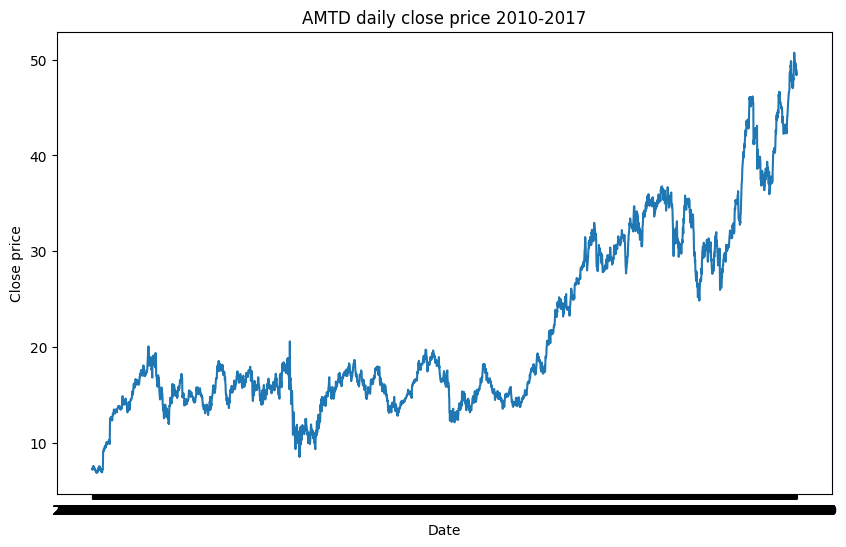

In [7]:
amtd_model.plot_daily_close()

In [8]:
amtd_model.plot_train_test_val()

In [9]:
amtd_model.train()

Epoch 1/50
80/80 [==============================] - 16s 26ms/step - loss: 165.0943 - val_loss: 822.2150
Epoch 2/50
80/80 [==============================] - 1s 9ms/step - loss: 55.9260 - val_loss: 659.0044
Epoch 3/50
80/80 [==============================] - 1s 9ms/step - loss: 42.5411 - val_loss: 582.6383
Epoch 4/50
80/80 [==============================] - 1s 9ms/step - loss: 39.4431 - val_loss: 551.2222
Epoch 5/50
80/80 [==============================] - 1s 9ms/step - loss: 38.7588 - val_loss: 539.9471
Epoch 6/50
80/80 [==============================] - 1s 9ms/step - loss: 39.3401 - val_loss: 536.3448
Epoch 7/50
80/80 [==============================] - 1s 9ms/step - loss: 38.7573 - val_loss: 536.4097
Epoch 8/50
80/80 [==============================] - 1s 9ms/step - loss: 39.1940 - val_loss: 539.6283
Epoch 9/50
80/80 [==============================] - 1s 9ms/step - loss: 39.1976 - val_loss: 540.4479
Epoch 10/50
80/80 [==============================] - 1s 9ms/step - loss: 39.4817 - val_l

10/10 [==============================] - 1s 4ms/step


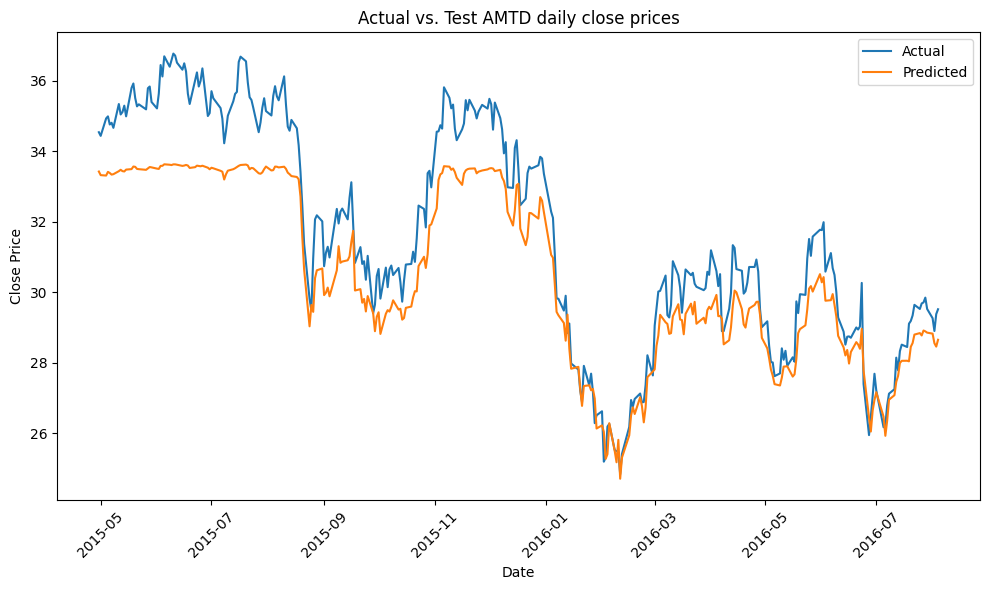

In [10]:
amtd_model.predict()

In [11]:
from keras.optimizers import Adam
from keras import regularizers
msft_model = PriceClassifier("msft")
model = Sequential()
model.add(LSTM(units=50,input_shape=(msft_model.X_train.shape[1], 1), dropout=.2, recurrent_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-3), return_sequences=True))
model.add(LSTM(units=50,input_shape=(msft_model.X_train.shape[1], 1), dropout=.2, recurrent_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-3)))

model.add(Dense(units=1))
optimizer = Adam()
msft_model.train(model=model, optimizer=optimizer, epochs=50, loss="mean_squared_error")

Epoch 1/50
200/200 [==============================] - 6s 10ms/step - loss: 94.6114 - val_loss: 1440.0500
Epoch 2/50
200/200 [==============================] - 1s 7ms/step - loss: 20.6057 - val_loss: 1131.0630
Epoch 3/50
200/200 [==============================] - 2s 9ms/step - loss: 10.8598 - val_loss: 974.0013
Epoch 4/50
200/200 [==============================] - 2s 9ms/step - loss: 7.3645 - val_loss: 862.3494
Epoch 5/50
200/200 [==============================] - 1s 7ms/step - loss: 6.2813 - val_loss: 771.8149
Epoch 6/50
200/200 [==============================] - 1s 6ms/step - loss: 5.3381 - val_loss: 702.8293
Epoch 7/50
200/200 [==============================] - 1s 6ms/step - loss: 4.0648 - val_loss: 647.8796
Epoch 8/50
200/200 [==============================] - 1s 7ms/step - loss: 4.0689 - val_loss: 602.0711
Epoch 9/50
200/200 [==============================] - 1s 7ms/step - loss: 3.2151 - val_loss: 563.4971
Epoch 10/50
200/200 [==============================] - 1s 6ms/step - loss: 2

25/25 [==============================] - 1s 4ms/step


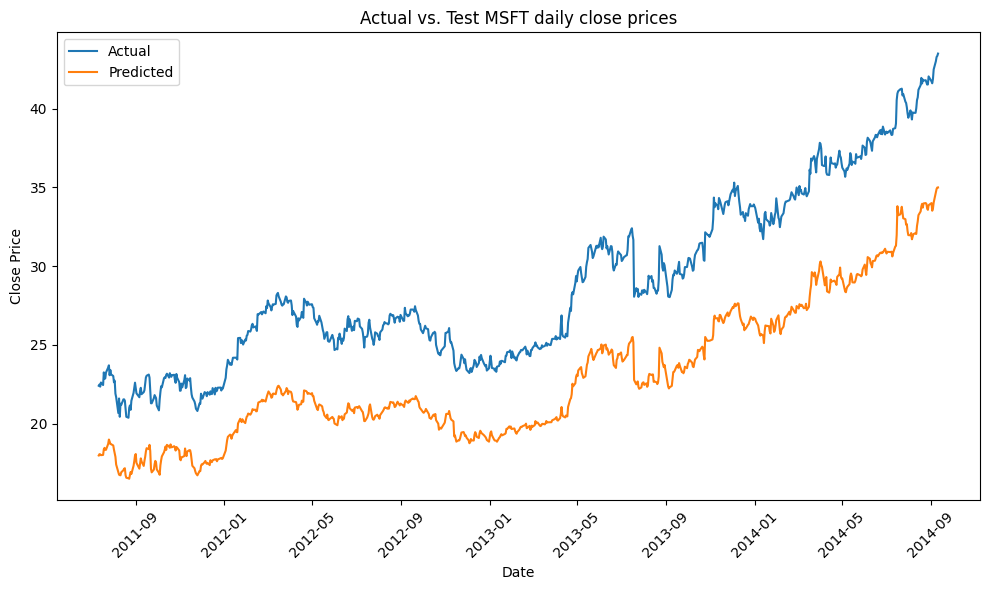

In [12]:
msft_model.predict()

In [19]:
cern_model = PriceClassifier("cern")
cern_model.train(epochs=150, loss="mean_squared_error")

Epoch 1/150
80/80 [==============================] - 9s 28ms/step - loss: 732.0542 - val_loss: 2390.1611
Epoch 2/150
80/80 [==============================] - 1s 10ms/step - loss: 486.3261 - val_loss: 2030.8524
Epoch 3/150
80/80 [==============================] - 1s 11ms/step - loss: 412.9282 - val_loss: 1773.1218
Epoch 4/150
80/80 [==============================] - 1s 11ms/step - loss: 369.7734 - val_loss: 1585.2787
Epoch 5/150
80/80 [==============================] - 1s 15ms/step - loss: 350.0956 - val_loss: 1446.0962
Epoch 6/150
80/80 [==============================] - 1s 15ms/step - loss: 337.6326 - val_loss: 1354.1089
Epoch 7/150
80/80 [==============================] - 2s 19ms/step - loss: 258.3758 - val_loss: 1168.2637
Epoch 8/150
80/80 [==============================] - 2s 20ms/step - loss: 185.9409 - val_loss: 959.9509
Epoch 9/150
80/80 [==============================] - 1s 17ms/step - loss: 146.3739 - val_loss: 794.7996
Epoch 10/150
80/80 [==============================] - 1s 

In [14]:
cern_model.plot_train_test_val()

10/10 [==============================] - 1s 4ms/step


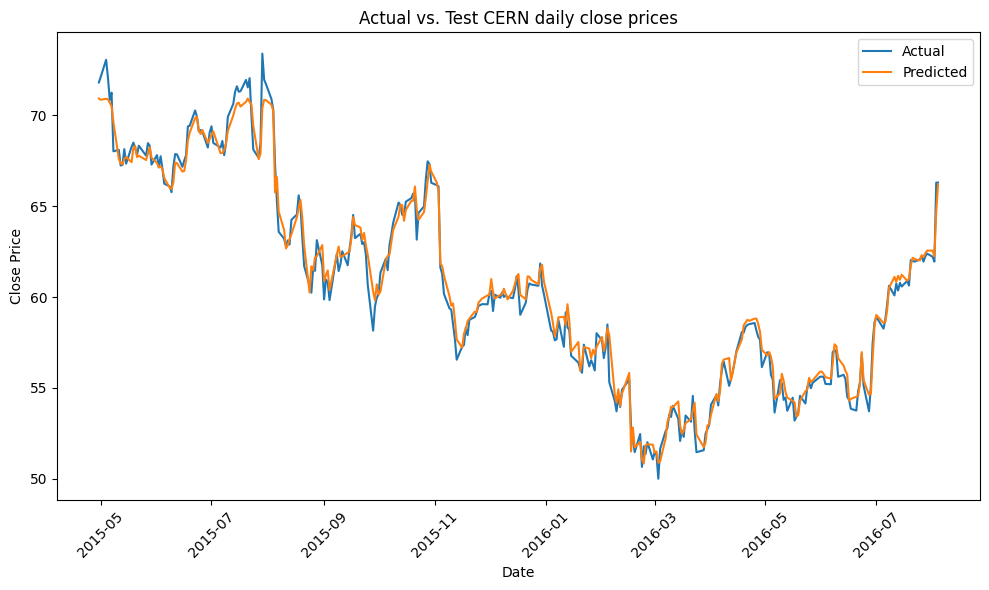

In [20]:
cern_model.predict()

In [21]:
amzn_model = PriceClassifier("amzn")
amzn_model.train(epochs=150, loss="mean_squared_error")

Epoch 1/150
129/129 [==============================] - 12s 24ms/step - loss: 10745.3174 - val_loss: 632305.8125
Epoch 2/150
129/129 [==============================] - 2s 12ms/step - loss: 9594.0322 - val_loss: 622136.3750
Epoch 3/150
129/129 [==============================] - 2s 12ms/step - loss: 8812.1748 - val_loss: 612584.3750
Epoch 4/150
129/129 [==============================] - 2s 12ms/step - loss: 8151.2412 - val_loss: 603639.5000
Epoch 5/150
129/129 [==============================] - 1s 12ms/step - loss: 7565.5537 - val_loss: 595210.6875
Epoch 6/150
129/129 [==============================] - 2s 15ms/step - loss: 7049.7871 - val_loss: 587079.2500
Epoch 7/150
129/129 [==============================] - 2s 17ms/step - loss: 6590.3408 - val_loss: 579342.3750
Epoch 8/150
129/129 [==============================] - 2s 15ms/step - loss: 6156.2827 - val_loss: 571745.8125
Epoch 9/150
129/129 [==============================] - 2s 12ms/step - loss: 5755.8428 - val_loss: 564463.8750
Epoch 10

In [22]:
amzn_model.plot_train_test_val()

17/17 [==============================] - 1s 5ms/step


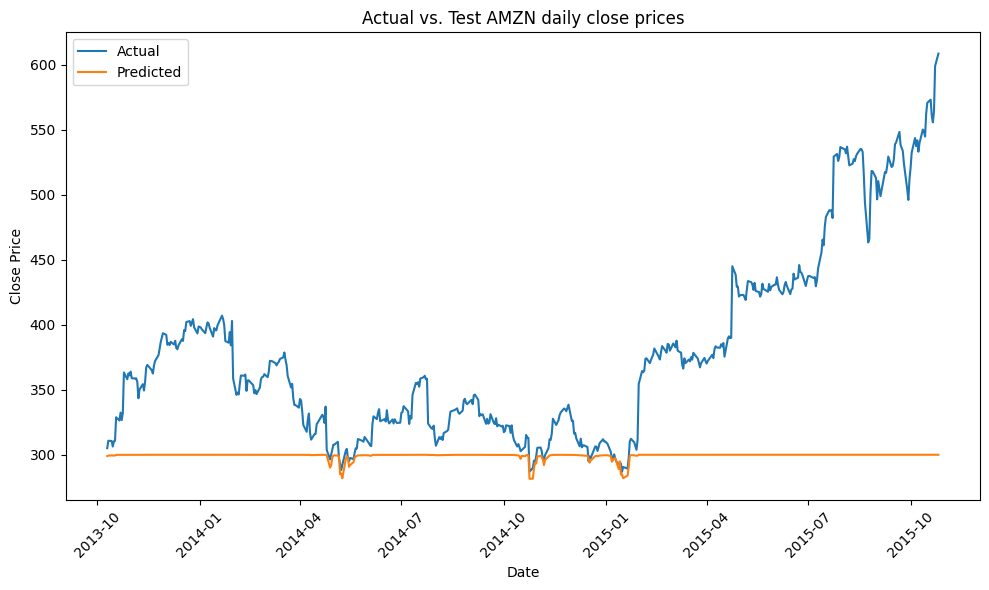

In [23]:
amzn_model.predict()

--------------------------------------------------------------------------------


Correlation Stuff

In [16]:
import pandas as pd
import glob

# List all CSV files in the current directory
csv_files = ['aa.us.txt', 'abb.us.txt', 'aau.us.txt']

# Create an empty DataFrame to store merged data
merged_data = None

# Read and merge data from all CSV files
for file in csv_files:
    stock_data = pd.read_csv(file)
    if merged_data is None:
      merged_data = stock_data
    else:
      merged_data = pd.merge(merged_data, stock_data, on='Date', how='outer')

merged_data.dropna(inplace=True)
print(merged_data.head())

# Calculate correlation for each pair of stocks
correlation_matrix = merged_data.corr()

print(correlation_matrix)


            Date  Open_x  High_x   Low_x  Close_x  Volume_x  OpenInt_x  \
8872  2005-02-25  65.687  66.812  65.561   66.039   2935168          0   
8873  2005-02-28  66.565  67.170  66.290   67.063   3229626          0   
8874  2005-03-01  67.042  67.421  65.875   66.104   2386346          0   
8875  2005-03-02  65.561  66.016  64.770   65.353   1973783          0   
8876  2005-03-03  65.977  66.227  64.889   65.310   1857445          0   

      Open_y  High_y   Low_y  Close_y  Volume_y  OpenInt_y  Open  High   Low  \
8872  4.4844  4.5556  4.4765   4.5082  319324.0        0.0  1.58  1.58  1.53   
8873  4.5873  4.5873  4.4685   4.5082  534773.0        0.0  1.64  1.64  1.54   
8874  4.5479  4.5873  4.5399   4.5717  409945.0        0.0  1.53  1.61  1.53   
8875  4.5717  4.5954  4.5399   4.5636  239933.0        0.0  1.53  1.53  1.53   
8876  4.6112  4.6666  4.5873   4.6270  962639.0        0.0  1.54  1.54  1.49   

      Close   Volume  OpenInt  
8872   1.58   8570.0      0.0  
8873   1.6